# Training BERT, SciBERT and PubMedBERT

## 0. Setup

### 0.1 Install libraries

In [1]:
! pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 0.2 GPU setup

In [2]:
# Check if CUDA is available and print the current device's name
import torch
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(0))

True
0
NVIDIA GeForce RTX 2070 with Max-Q Design


## 1. Configuration

In [3]:
data_path = r"../../data/labeled/2025-06-28_labeled_data.xlsx"
text_column_name = "expanded"
label_column_name = "label_strict"

model_name = "bert-base-uncased" # standard; I specify other models in the "3. Initialize Models" section of this script
test_size = 0.2
num_labels = 2

## 2. Read and prepare dataset

In [4]:
import pandas as pd

# Load the data
df = pd.read_excel(data_path)

# Remove all columns but 'expanded' and 'label_strict'
df = df.drop(columns=['statement_id', 'section', 'header','div', 'p', 's', 'article_id', 'p_comp', 'p_value', 'context', 'text', 'label_kind', 'label_keywords', 'label_comment'])

# Change column names
df = df.rename(columns={text_column_name: 'text', label_column_name: 'label'})

# Remove rows where 'label' is NA or -99
df = df[~df['label'].isna() & (df['label'] != -99)]

# Convert label column to int (required for classification)
df['label'] = df['label'].astype(int)

# Balance the dataset: all 1s and an equal number of random 0s
ones = df[df['label'] == 1]
zeros = df[df['label'] == 0].sample(n=len(ones), random_state=42)
df = pd.concat([ones, zeros]).sample(frac=1, random_state=42).reset_index(drop=True)

# Show head
df.head()

,text,label
0,The analysis of polarization based on this sin...,1
1,"Moreover, no effect of channel-group lateralit...",0
2,Change-detection RTs in Experiment 1 were not ...,1
3,The Pearson correlation test (p > .05 in the S...,0
4,"Variability in movement end points, calculated...",1


### 2.1 Create Train/Test set

In [5]:
from sklearn.model_selection import train_test_split

# Separate by label
ones = df[df['label'] == 1]
zeros = df[df['label'] == 0]

# Split each class into train/test
ones_train, ones_test = train_test_split(ones, test_size=test_size, random_state=42)
zeros_train, zeros_test = train_test_split(zeros, test_size=test_size, random_state=42)

# Combine to make balanced train/test sets
df_train = pd.concat([ones_train, zeros_train]).sample(frac=1, random_state=42).reset_index(drop=True)
df_test = pd.concat([ones_test, zeros_test]).sample(frac=1, random_state=42).reset_index(drop=True)

# Convert to Huggingface dataset
from datasets import Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

c:\Users\Raphael\Documents\GitHub\nonsig-master-thesis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Header of the Training set:

In [6]:
df_train.head()

,text,label
0,Risk taking did not differ between participant...,1
1,"Notably, distance never significantly predicte...",0
2,Although perceiving an opportunity to empathiz...,1
3,Leader narcissism levels also did not signific...,0
4,"Although the number of morphs identified as ""d...",1


In [7]:
# Check label balance in training set
df_train['label'].value_counts()

label
1    159
0    159
Name: count, dtype: int64

Header of the Test set:

In [8]:
df_test.head()

,text,label
0,Post hoc simple-effects analyses revealed that...,1
1,A length effect was found for pseudowords (fiv...,1
2,"First, participant height (added as a fixed fa...",1
3,"However, velocity was not increased or decreas...",1
4,We observed no such increase in the congruent ...,1


In [9]:
# Check label balance in test set
df_test['label'].value_counts()

label
1    40
0    40
Name: count, dtype: int64

### 2.2 Tokenize 'text'

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=350)

tokenized_train = train_dataset.map(preprocess_function, batched=True)

tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 80/80 [00:00<00:00, 4404.91 examples/s]


#### 2.2.1 Comparing tokenized and untokenized statements

In [11]:
# Collect comparison data for the first 20 samples (adjust as needed)
comparison = []
for i in range(224):
    original = train_dataset[i]['text']
    input_ids = tokenized_train[i]['input_ids']
    decoded = tokenizer.decode(input_ids, skip_special_tokens=True)
    comparison.append({
        "original_text": original,
        "tokenized_ids": input_ids,
        "decoded_text": decoded
    })

# Create DataFrame
df_comparison = pd.DataFrame(comparison)

# Show header
df_comparison.head(10)

# Save to CSV
# df_comparison.to_csv("tokenization_comparison.csv", index=False)
# print("Saved as tokenization_comparison.csv")

,original_text,tokenized_ids,decoded_text
0,Risk taking did not differ between participant...,"[101, 3891, 2635, 2106, 2025, 11234, 2090, 681...",risk taking did not differ between participant...
1,"Notably, distance never significantly predicte...","[101, 5546, 1010, 3292, 2196, 6022, 10173, 111...","notably, distance never significantly predicte..."
2,Although perceiving an opportunity to empathiz...,"[101, 2348, 2566, 3401, 14966, 2019, 4495, 200...",although perceiving an opportunity to empathiz...
3,Leader narcissism levels also did not signific...,"[101, 3003, 6583, 11890, 14643, 2964, 3798, 20...",leader narcissism levels also did not signific...
4,"Although the number of morphs identified as ""d...","[101, 2348, 1996, 2193, 1997, 22822, 18757, 44...","although the number of morphs identified as "" ..."
5,"Most importantly, test anxiety did not predict...","[101, 2087, 14780, 1010, 3231, 10089, 2106, 20...","most importantly, test anxiety did not predict..."
6,"There was no significant interaction, F(2.74, ...","[101, 2045, 2001, 2053, 3278, 8290, 1010, 1042...","there was no significant interaction, f ( 2. 7..."
7,"The triple interaction (Î² = -0.02, 95% CI = [...","[101, 1996, 6420, 8290, 1006, 1045, 10701, 102...","the triple interaction ( i² = - 0. 02, 95 % ci..."
8,A control model additionally revealed a main e...,"[101, 1037, 2491, 2944, 5678, 3936, 1037, 2364...",a control model additionally revealed a main e...
9,Neither the reaction time nor the proportion o...,"[101, 4445, 1996, 4668, 2051, 4496, 1996, 1081...",neither the reaction time nor the proportion o...


## 3. Regular BERT

### 3.1 Initializing regular BERT

In [12]:
from transformers import AutoModelForSequenceClassification

model_bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.2 Training regular BERT

In [13]:
# Standard Setup for training a model with Huggingface Transformers
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5, # Specify learning rate for BERT
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none",
)

# Model specific setup
trainer_bert = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_22864\617370419.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert = Trainer(


In [14]:
trainer_bert.train()

Step,Training Loss
40,0.695900
80,0.490100
120,0.157900
160,0.059100
200,0.043200


TrainOutput(global_step=200, training_loss=0.2892455101013184, metrics={'train_runtime': 66.3585, 'train_samples_per_second': 23.961, 'train_steps_per_second': 3.014, 'total_flos': 226332035375400.0, 'train_loss': 0.2892455101013184, 'epoch': 5.0})

#### 3.2.1 Save last model

In [15]:
# trainer_bert.save_model('bert_model')

### 3.3 Evaluate model

#### 3.3.1 Predict training data

In [16]:
from sklearn.metrics import classification_report

preds = trainer_bert.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       159
           1       0.99      0.99      0.99       159

    accuracy                           0.99       318
   macro avg       0.99      0.99      0.99       318
weighted avg       0.99      0.99      0.99       318



#### 3.3.2 Predict test data

In [17]:
preds = trainer_bert.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.81      0.97      0.89        40
           1       0.97      0.78      0.86        40

    accuracy                           0.88        80
   macro avg       0.89      0.88      0.87        80
weighted avg       0.89      0.88      0.87        80



#### 3.3.3 4.3.3 Confusion-Matrix for test data

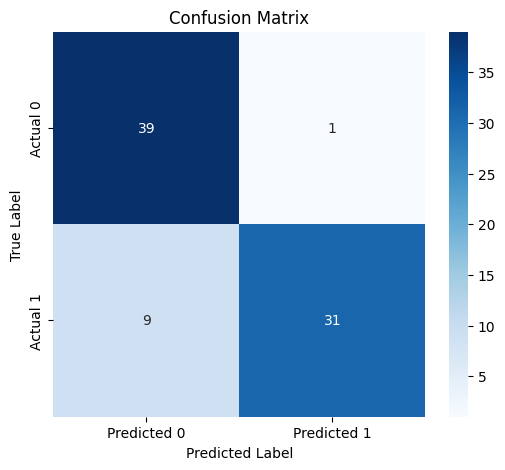

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT, preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### 3.3.4 List of statements per category (TP, TN, FP, FN)

In [19]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [20]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 31)


,text
0,Post hoc simple-effects analyses revealed that...
1,"First, participant height (added as a fixed fa..."
2,"However, velocity was not increased or decreas..."
3,We observed no such increase in the congruent ...
4,"In contrast, atomoxetine did not increase risk..."
5,Non-attraction-effect choices were very rare a...
6,"For adults, patterns were similar to those in ..."
7,There was no correlation between the reproduce...
8,Results were also independent of the reliabili...
9,This finding was similar to that in the forced...


In [21]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 39)


,text
0,Tukey's honestly significant difference (HSD) ...
1,We found no significant difference between the...
2,There were no significant differences by gende...
3,Among participants using the optimal strategy ...
4,The effect of transaction frame did not signif...
5,The effect of host-country tightness was not s...
6,The LPE effect was reduced to 3.3% in the simi...
7,"In contrast, non-White AI faces (left side of ..."
8,"However, pupil dilation was not significantly ..."
9,Results revealed no significant relationships ...


In [22]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 1)


,text
0,Being in an oppositional climate (vs. the bala...


In [23]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 9)


,text
0,A length effect was found for pseudowords (fiv...
1,A Position Ã— Set Size repeatedmeasures ANOVA ...
2,We next focused on report error and found a ma...
3,"Consistent with these observations, a repeated..."
4,"Unlike RT, accuracy did not significantly diff..."
5,The Participant Group Ã— Tweet type interactio...
6,We found no systematic difference between the ...
7,"As before, this interaction resulted from a si..."
8,"For congruency, larger EPN amplitudes (incongr..."


## 4. SciBERT

### 4.1 Initializing SciBERT

In [24]:
from transformers import AutoModelForSequenceClassification

model_scibert = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=num_labels, trust_remote_code=True,
    use_safetensors=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.2 Training SciBERT

In [25]:
# Standard Setup for training a model with Huggingface Transformers
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5, # Specify learning rate for BERT
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none",
)

# Model specific setup
trainer_scibert = Trainer(
    model=model_scibert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_22864\2136063693.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_scibert = Trainer(


In [26]:
trainer_scibert.train()

Step,Training Loss
40,0.707800
80,0.620500
120,0.454700
160,0.229300
200,0.131000


TrainOutput(global_step=200, training_loss=0.4286613869667053, metrics={'train_runtime': 73.178, 'train_samples_per_second': 21.728, 'train_steps_per_second': 2.733, 'total_flos': 226332035375400.0, 'train_loss': 0.4286613869667053, 'epoch': 5.0})

#### 4.2.1 Save last model

In [27]:
# trainer_scibert.save_model('scibert_model')

### 4.3 Evaluate model

#### 4.3.1 Predict training data

In [28]:
from sklearn.metrics import classification_report

preds = trainer_scibert.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       159
           1       0.98      0.98      0.98       159

    accuracy                           0.98       318
   macro avg       0.98      0.98      0.98       318
weighted avg       0.98      0.98      0.98       318



#### 4.3.2 Predict test data

In [29]:
preds = trainer_scibert.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78        40
           1       0.82      0.68      0.74        40

    accuracy                           0.76        80
   macro avg       0.77      0.76      0.76        80
weighted avg       0.77      0.76      0.76        80



#### 4.3.3 Confusion-Matrix for test data

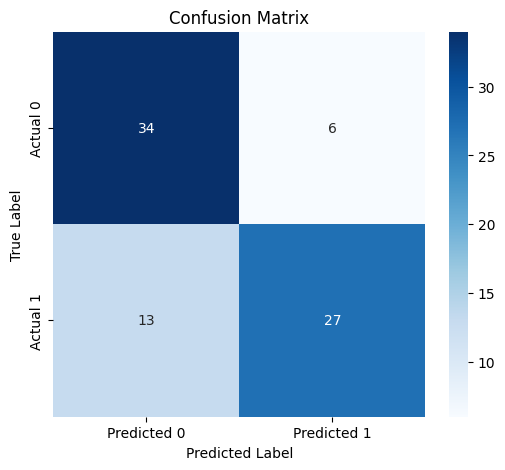

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT, preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### 4.3.4 List of statements per category (TP, TN, FP, FN)

In [31]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [32]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 27)


,text
0,"First, participant height (added as a fixed fa..."
1,"However, velocity was not increased or decreas..."
2,We observed no such increase in the congruent ...
3,"For adults, patterns were similar to those in ..."
4,There was no correlation between the reproduce...
5,Results were also independent of the reliabili...
6,This finding was similar to that in the forced...
7,"Importantly, it was comparable with that in th..."
8,"Depending on the outcome measure, individuals ..."
9,Time of day did not interact with type of day ...


In [33]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 34)


,text
0,Tukey's honestly significant difference (HSD) ...
1,We found no significant difference between the...
2,There were no significant differences by gende...
3,The effect of transaction frame did not signif...
4,The effect of host-country tightness was not s...
5,The LPE effect was reduced to 3.3% in the simi...
6,"However, pupil dilation was not significantly ..."
7,Results revealed no significant relationships ...
8,The three-way Configuration Ã— Decoy Ã— Choice...
9,"For the recognition data, the NHST analysis sh..."


In [34]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 6)


,text
0,Among participants using the optimal strategy ...
1,"In contrast, non-White AI faces (left side of ..."
2,Study S2 shows that participants imagined peop...
3,"For groups added to the analysis, no significa..."
4,Participants in the ultimatum game were nonsig...
5,Being in an oppositional climate (vs. the bala...


In [35]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 13)


,text
0,Post hoc simple-effects analyses revealed that...
1,A length effect was found for pseudowords (fiv...
2,"In contrast, atomoxetine did not increase risk..."
3,Non-attraction-effect choices were very rare a...
4,A Position Ã— Set Size repeatedmeasures ANOVA ...
5,"Consistent with these observations, a repeated..."
6,Children and adults pressed the button with eq...
7,"Unlike RT, accuracy did not significantly diff..."
8,For âˆ†Î¸ Ë†crit values derived from highversu...
9,"However, auditory attention ability did not pr..."


## 5. PubMedBERT

### 5.1 Initializing PubMedBERT

In [36]:
from transformers import AutoModelForSequenceClassification

model_pubmedbert = AutoModelForSequenceClassification.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract", num_labels=num_labels, trust_remote_code=True,
    use_safetensors=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5.2 Training PubMedBERT

In [37]:
# Standard Setup for training a model with Huggingface Transformers
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5, # Specify learning rate for BERT
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none",
)

# Model specific setup
trainer_pubmedbert = Trainer(
    model=model_pubmedbert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_22864\2526163365.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_pubmedbert = Trainer(


In [38]:
trainer_pubmedbert.train()

Step,Training Loss
40,0.718600
80,0.666200
120,0.479600
160,0.276500
200,0.185600


TrainOutput(global_step=200, training_loss=0.46531842231750487, metrics={'train_runtime': 75.6988, 'train_samples_per_second': 21.004, 'train_steps_per_second': 2.642, 'total_flos': 226332035375400.0, 'train_loss': 0.46531842231750487, 'epoch': 5.0})

#### 5.2.1 Save last model

In [39]:
# trainer_pubmedbert.save_model('pubmedbert_model')

### 5.3 Evaluate model

#### 5.3.1 Predict training data

In [40]:
from sklearn.metrics import classification_report

preds = trainer_pubmedbert.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       159
           1       0.99      0.96      0.97       159

    accuracy                           0.97       318
   macro avg       0.98      0.97      0.97       318
weighted avg       0.98      0.97      0.97       318



#### 5.3.2 Predict test data

In [41]:
preds = trainer_pubmedbert.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.63      0.85      0.72        40
           1       0.77      0.50      0.61        40

    accuracy                           0.68        80
   macro avg       0.70      0.68      0.66        80
weighted avg       0.70      0.68      0.66        80



#### 5.3.3 Confusion-Matrix for test data

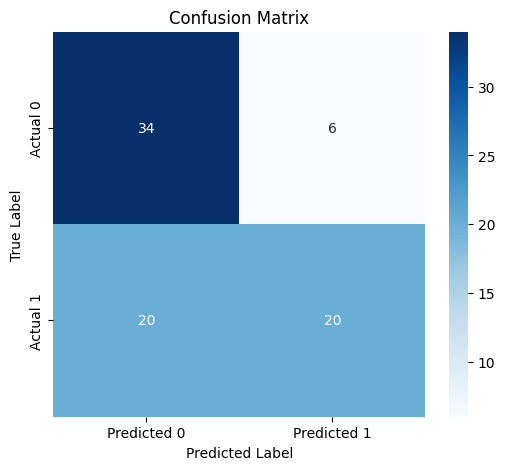

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT, preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### 5.3.4 List of statements per category (TP, TN, FP, FN)

In [43]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [44]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 20)


,text
0,Post hoc simple-effects analyses revealed that...
1,"However, velocity was not increased or decreas..."
2,We observed no such increase in the congruent ...
3,"For adults, patterns were similar to those in ..."
4,There was no correlation between the reproduce...
5,"Importantly, it was comparable with that in th..."
6,There was no difference in the ratings given t...
7,There was no effect of session for bimodal bil...
8,Children and adults pressed the button with eq...
9,"In contrast, there was no difference between t..."


In [45]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 34)


,text
0,Tukey's honestly significant difference (HSD) ...
1,We found no significant difference between the...
2,There were no significant differences by gende...
3,The effect of transaction frame did not signif...
4,The effect of host-country tightness was not s...
5,The LPE effect was reduced to 3.3% in the simi...
6,Results revealed no significant relationships ...
7,The three-way Configuration Ã— Decoy Ã— Choice...
8,We found no gender differences in task perform...
9,We ran a mixed analysis of variance on the per...


In [46]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 6)


,text
0,Among participants using the optimal strategy ...
1,"In contrast, non-White AI faces (left side of ..."
2,"However, pupil dilation was not significantly ..."
3,"For the recognition data, the NHST analysis sh..."
4,Study S2 shows that participants imagined peop...
5,"Further, the reactivation-only group, t(68) = ..."


In [47]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 20)


,text
0,A length effect was found for pseudowords (fiv...
1,"First, participant height (added as a fixed fa..."
2,"In contrast, atomoxetine did not increase risk..."
3,Non-attraction-effect choices were very rare a...
4,A Position Ã— Set Size repeatedmeasures ANOVA ...
5,Results were also independent of the reliabili...
6,This finding was similar to that in the forced...
7,"Depending on the outcome measure, individuals ..."
8,Time of day did not interact with type of day ...
9,We next focused on report error and found a ma...


In [ ]:
# The end...